In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

# Overview

- In order to use MC sampling to infer the pose of the agent we build a model that generates sensor data. The way we represent and model the sensor data has an impact on the inference procedures and performance respectively.
- Here we study a single step in online SLAM inference (see graphical model), and show that a sensor with *drop out* performs much better than a sensor without.
- I will present a sensor model that produces depth measurement along a bouquet of simulated laser beams. In Section X I illustrate that making the model too "rigid" yields to poor pose inference, and that "loosen" up the model by introducing the probability of failure, or **drop out**, of a measurement resolves this issue. 
- This issue does not occur when we use a different data generating model (I still have to check that but I am pretty certain). In classic implementations of (occupancy map) SLAM algorithms, in order to compute $p(z \mid x, m) \propto p(m \mid x, z)\cdot p(z)$ one only uses the likelihood $p(m \mid x, z)$, called the *inverse sensor model*, which produces a pixel image (in the case of occupancy maps) of the surrounding of the agent from depth measurements. It is less susceptible to the perturbation described in Section X.

**Visual summary:**
![localization step](png/localization_step.png)
![dropout 0](png/dropout_0.png)
![dropout 20](png/dropout_20.png)

- **Fig: Sensor drop out.** Sensor with no drop out in top row vs 20% dropout in bottom row.

In [2]:
using Gen
using Random
using Distributions
using StatsBase: mean, std, quantile
using BenchmarkTools
using FilePathsBase;
using LinearAlgebra: dot, Diagonal, norm
using JSON
import PyPlot
plt = PyPlot.plt
using JLD

include("src/utils.jl");
include("src/expo_environment.jl")
include("src/part_1.jl");
include("src/part_2.jl");

In [3]:
@gen function model(M::Map, 
                    pose::Pose, 
                    u::Control,
                    motion_args,
                    sensor_args)
    
    pose  = @trace(motion_model(pose, u, motion_args...), :pose)
    sense = @trace(sensor_model(M, pose, sensor_args...), :sense)
    
    return pose
end;

# Load measurement and control data

In [4]:
data = load("example_sensor_data.jld")

┌ Warning: JLD incorrectly extends FileIO functions (see FileIO documentation)
└ @ FileIO /Users/mirko/.julia/packages/FileIO/AmppF/src/loadsave.jl:210


Dict{String,Any} with 10 entries:
  "n"       => 100
  "s"       => [1.0, 1.0, 0.949818, 1.0, 1.0, 1.0, 1.0, 1.0, 0.631622, 1.0, 1.0…
  "fov"     => 180
  "hd"      => [2.68723, 2.68723, 2.68723, 2.68723, 2.02111, 2.96523, 2.96523, …
  "env_id"  => 2010
  "x"       => Any[[15.474, 1.94666], [14.5754, 2.38555], [13.6769, 2.82444], […
  "z"       => Any[[0.949706, 0.925378, 0.905751, 0.89038, 0.878933, 0.871171, …
  "a"       => Any[[-3.11018, -3.04734, -2.98451, -2.92168, -2.85885, -2.79602,…
  "dhd"     => [0.0, 0.0, -8.88178e-16, -0.666124, 0.944122, -4.44089e-16, 4.44…
  "max_val" => Inf

In [5]:
env_id = data["env_id"]
env = load_env(env_id; path=p"data/HouseExpo_json");

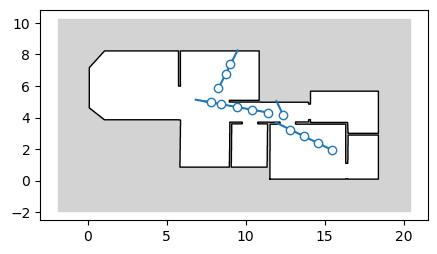

12


In [22]:
fov, n, max_val = data["fov"], data["n"], data["max_val"]

poses = []
senses = []
us = []

for (x, hd) in zip(data["x"], data["hd"])
    push!(poses, Pose(x, hd))
end


for (s,dhd) in zip(data["s"], data["dhd"])
    push!(us, Control(s,dhd))
end


for (z,a) in zip(data["z"], data["a"])
    push!(senses, Measurement(z, a))
end


T = length(us)

println(T)
# -------
plt.figure(figsize=(5,5)); plt.gca().set_aspect(1.);
plt.title("True poses of the agent")
draw_env!(env, zorder=-1);
for p in poses
    draw_pose!(p, c="C0")
end

# MC pose inference

In [12]:
function thresh(M::Map, θ::Float64)
    v = Float64.(val.(M.cells) .> θ)
    return Map(size(M), M.res, v)
end

thresh (generic function with 1 method)

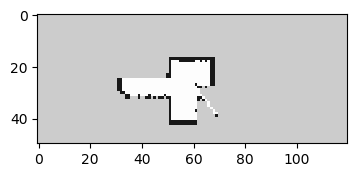

PyObject <matplotlib.image.AxesImage object at 0x7f85f0198c10>

In [18]:
free, prior, occ = ell(0.01), ell(0.2), ell(0.9)
occ_thresh = ell(0.5)

map_args     = (map_size=(120,50), res=.3, ell0=prior)
control_args = (mean_speed=1., max_speed=2., dhd_noise=0.1*2π)
motion_args  = (hd_noise=0.05, x_noise=0.1)
sensor_args  = (fov=180, n=100, max_val=20., noise=.1, drop_out=0.2)

z_eps = map_args.res

t = 11

m0 = Map(map_args...)
p0 = Pose([0;0], mod(poses[t].hd,2π))
inverse_polar_lidar!(m0, p0, senses[t], z_eps, free, prior, occ)
true_p = Pose(poses[t+1].x - poses[t].x, poses[t+1].hd)

m = thresh(m0, occ_thresh)
u = us[t+1]
constr = choicemap()
constr[:sense => :z] = senses[t+1].z

im = expit.(val.(m0.cells))


fig, ax = plt.subplots(1,1, figsize=(4,4));
draw_map_im!(im, vmin=0, vmax=1, ax=ax)

In [19]:
function do_inference(drop_out, steps)
    sensor_args = (fov=180, n=100, max_val=20., noise=.1, drop_out=drop_out)
    
    trs, ws, = importance_sampling(model, 
                        (m, p0, u, motion_args, sensor_args), 
                        constr, steps);
    perm = sortperm(ws);
    trs = trs[perm];
    ws = ws[perm];
    return trs, ws
end


function draw_result!(trs, ws)
    
    M, p, = get_args(trs[end])
    xs = hcat([tr[:pose].x for tr in trs]...)

    q = quantile(ws, 0.9)
    cs = clamp.(ws, q, 0)
    cs .-= min(cs...);
    cs ./= max(cs...);


    sense = trs[end][:sense];
    
    fig, axs = plt.subplots(1,2, figsize=(15,8))
    for ax in axs
        ax.set_aspect(1)
        ax.set_xlim(-10,10)
        ax.set_ylim(-6,5)    
        draw_sq_map!(M, ax=ax)
    end

    axs[1].scatter(xs[1,:], xs[2,:], c=ws, cmap="viridis")
    axs[1].scatter(true_p.x..., marker="x", c="r")
    axs[1].scatter(p.x..., marker="^", c="r")

    draw_pose!(trs[end][:pose], ax=axs[2], l=0.5)
    draw_sense!(sense, trs[end][:pose], ax=axs[2])
end

draw_result! (generic function with 1 method)

**Drop out: 0%**

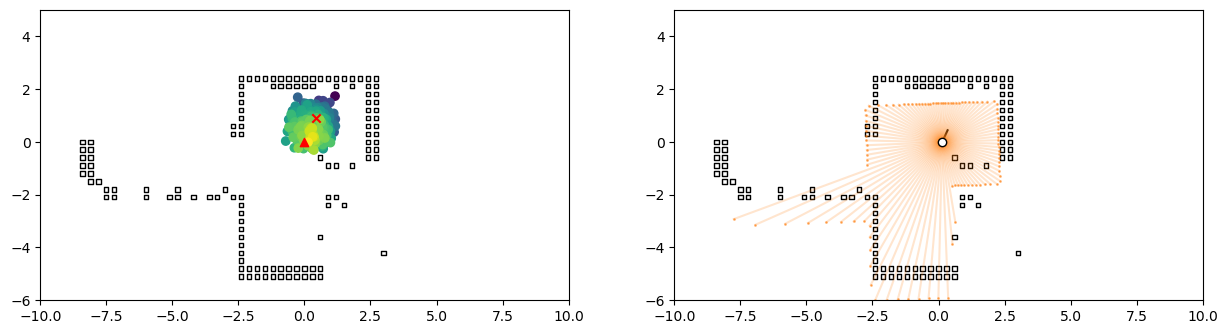

PyObject <matplotlib.collections.PathCollection object at 0x7f85ea604f90>

In [20]:
trs, ws = do_inference(0.0, 1000)
draw_result!(trs, ws)

**Drop out: 20%**

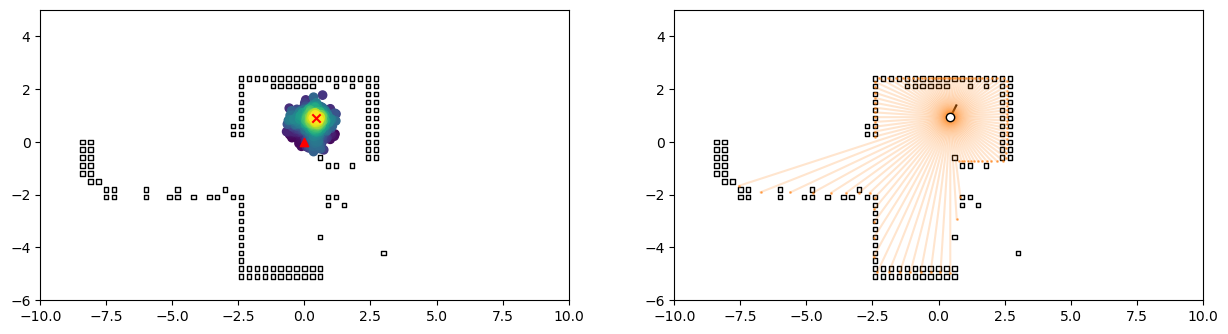

PyObject <matplotlib.collections.PathCollection object at 0x7f85edcbd950>

In [21]:
trs, ws = do_inference(.2, 1000)
draw_result!(trs, ws)

**Drop out: 100%**

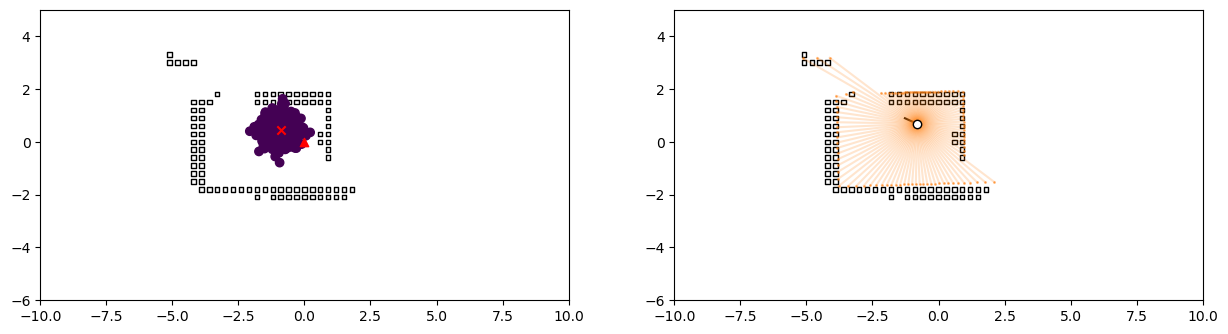

PyObject <matplotlib.collections.PathCollection object at 0x7f85ee6b1710>

In [17]:
trs, ws = do_inference(1.0, 1000)
draw_result!(trs, ws)